# **Deep learning - Pràctica**
## Creació d'un model per al diagnòstic de glaucoma
### Jordi Salleras Alabau

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import keras_tuner as kt
import keras.backend as K
from sklearn.metrics import f1_score

### **Secció 1. Anàlisi Exploratòria de les dades**

In [2]:
# Fold 0
train_dataset_path = os.listdir('../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/train')
test_dataset_path = os.listdir('../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/test')
valid_dataset_path = os.listdir('../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/valid')
print(train_dataset_path)
print('Types of classes labels found: ' + str(len(train_dataset_path)))

['normal', 'abnormal']
Types of classes labels found: 2


In [3]:
train_path = '../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/train'
test_path = '../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/test'
valid_path = '../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/valid'
class_labels = []
for item in train_dataset_path:
    all_classes = os.listdir(train_path + '/' + item)    
    for image in all_classes:
        class_labels.append((item, str(train_path + '/' + item) + '/' + image))

df_train = pd.DataFrame(data=class_labels, columns = ['Label', 'Image'])
df_train['Split'] = 'Train'

class_labels = []
for item in test_dataset_path:
    all_classes = os.listdir(test_path + '/' + item)    
    for image in all_classes:
        class_labels.append((item, str(test_path + '/' + item) + '/' + image))
df_test = pd.DataFrame(data=class_labels, columns = ['Label', 'Image'])
df_test['Split'] = 'Test'

class_labels = []
for item in valid_dataset_path:
    all_classes = os.listdir(valid_path + '/' + item)    
    for image in all_classes:
        class_labels.append((item, str(valid_path + '/' + item) + '/' + image))
df_val = pd.DataFrame(data=class_labels, columns = ['Label', 'Image'])
df_val['Split'] = 'Val'

In [4]:
df = pd.concat([df_train, df_test, df_val])
df

,Label,Image,Split
0,normal,../input/glaucoma/archive/practica_DL_UOC_2022...,Train
1,normal,../input/glaucoma/archive/practica_DL_UOC_2022...,Train
2,normal,../input/glaucoma/archive/practica_DL_UOC_2022...,Train
3,normal,../input/glaucoma/archive/practica_DL_UOC_2022...,Train
4,normal,../input/glaucoma/archive/practica_DL_UOC_2022...,Train
...,...,...,...
149,abnormal,../input/glaucoma/archive/practica_DL_UOC_2022...,Val
150,abnormal,../input/glaucoma/archive/practica_DL_UOC_2022...,Val
151,abnormal,../input/glaucoma/archive/practica_DL_UOC_2022...,Val
152,abnormal,../input/glaucoma/archive/practica_DL_UOC_2022...,Val


In [5]:
df.to_csv('glaucoma.csv', index=None)

In [6]:
print('Total number of images in the train dataset: ', len(df))

label_count = df['Label'].value_counts()
print(label_count)

Total number of images in the train dataset:  1707
normal      919
abnormal    788
Name: Label, dtype: int64


In [7]:
def process_images_folder(folder_path):
    folder_path_dir = os.listdir(folder_path)
    img_size = 224

    images = []
    labels = []

    for i in folder_path_dir:
        data_path = folder_path + '/' + str(i)
        filenames = [i for i in os.listdir(data_path)]

        for f in filenames:
            img = cv2.imread(data_path + '/' + f)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(i)
    
    images = np.array(images)
    # images = images.astype('float32') / 255.0
    y = labels 
    ''' 
    y_labelEncoder = LabelEncoder()
    y = y_labelEncoder.fit_transform(y)
    #y = y.reshape(-1,1)
    y = to_categorical(y)
       
    ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
    Y = ct.fit_transform(y)
    '''
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    return images,encoded_y

In [8]:
X_train, y_train = process_images_folder('../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/train')
X_test, y_test = process_images_folder('../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/test')
X_val, y_val = process_images_folder('../input/glaucoma/archive/practica_DL_UOC_2022/Fold0/valid')

In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### **Secció 2. Entrenament d’una xarxa neuronal sobre una única partició**

# **EfficientNet implementation**

## Model 1

In [10]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
def model_builder(hp):
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = layers.Input(shape = (224,224,3), name='inputLayer')
    x = base_model(inputs, training = False)
    x = layers.GlobalAveragePooling2D(name='poolingLayer')(x)
    x = layers.BatchNormalization(name='batchLayer')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid", name='outputLayer')(x)

    model = tf.keras.Model(inputs, outputs, name = "Model1")

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=150,
                     factor=3)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

2022-06-05 16:23:52.838751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:23:52.965580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:23:52.966798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:23:52.968923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step


In [13]:
tuner.search(X_train, y_train, 
             epochs=150, 
             validation_data = (X_val, y_val), 
             callbacks=[callback])

Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.48051947355270386

Best val_accuracy So Far: 0.7077922224998474
Total elapsed time: 00h 01m 38s


In [14]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('learning_rate'))

0.001


In [15]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model1 = tuner.hypermodel.build(best_hps)
model1.summary()

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
poolingLayer (GlobalAverageP (None, 1280)              0         
_________________________________________________________________
batchLayer (BatchNormalizati (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 3,841
Non-trainable params: 4,052,131
______________________________________________

Epoch 1/100
44/44 [==============================] - 8s 81ms/step - loss: 0.6062 - accuracy: 0.6991 - val_loss: 0.6080 - val_accuracy: 0.6494
Epoch 2/100
44/44 [==============================] - 2s 44ms/step - loss: 0.4475 - accuracy: 0.7897 - val_loss: 0.5772 - val_accuracy: 0.6818
Epoch 3/100
44/44 [==============================] - 2s 45ms/step - loss: 0.4158 - accuracy: 0.8129 - val_loss: 0.5459 - val_accuracy: 0.6948
Epoch 4/100
44/44 [==============================] - 2s 45ms/step - loss: 0.3935 - accuracy: 0.8245 - val_loss: 0.5053 - val_accuracy: 0.7338
Epoch 5/100
44/44 [==============================] - 2s 44ms/step - loss: 0.3549 - accuracy: 0.8470 - val_loss: 0.4748 - val_accuracy: 0.7597
Epoch 6/100
44/44 [==============================] - 2s 49ms/step - loss: 0.3510 - accuracy: 0.8499 - val_loss: 0.4395 - val_accuracy: 0.7922
Epoch 7/100
44/44 [==============================] - 2s 50ms/step - loss: 0.3452 - accuracy: 0.8528 - val_loss: 0.4192 - val_accuracy: 0.8052
Epoch 

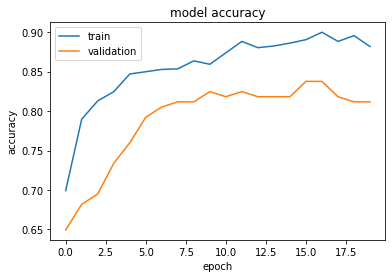

In [16]:
history = model1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[callback])
plot_hist(history)

In [17]:
model_eval = model1.evaluate(X_test, y_test, return_dict=True)

6/6 [==============================] - 0s 67ms/step - loss: 0.4055 - accuracy: 0.8391


In [18]:
preds = model1.predict(X_test)
preds1 = []
for pred in preds:
    if pred > 0.5:
        preds1.append(1)
    else:
        preds1.append(0)

print('**MODEL 1**')
cm1 = confusion_matrix(y_test, preds1)
print(f'Matriu de confusió: \n', cm1)
print('********'*7)
cr1 = classification_report(y_test, preds1)
print('Informe de la classificació: \n', cr1)
print('********'*7)
print('F1 Score: ',f1_score(y_test, preds1))
print('********'*7)
print('Resultats sobre test: ', model_eval)

**MODEL 1**
Matriu de confusió: 
 [[73 19]
 [ 9 73]]
********************************************************
Informe de la classificació: 
               precision    recall  f1-score   support

           0       0.89      0.79      0.84        92
           1       0.79      0.89      0.84        82

    accuracy                           0.84       174
   macro avg       0.84      0.84      0.84       174
weighted avg       0.84      0.84      0.84       174

********************************************************
F1 Score:  0.8390804597701148
********************************************************
Resultats sobre test:  {'loss': 0.40549159049987793, 'accuracy': 0.8390804529190063}


## Model 2

In [19]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    

model2 = keras.models.clone_model(model1)
model2.set_weights(model1.get_weights()) 
unfreeze_model(model2)
model2.summary()

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
poolingLayer (GlobalAverageP (None, 1280)              0         
_________________________________________________________________
batchLayer (BatchNormalizati (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 4,011,389
Non-trainable params: 44,583
_____________________________________________

Epoch 1/100
44/44 [==============================] - 21s 272ms/step - loss: 0.2497 - accuracy: 0.8970 - val_loss: 0.4069 - val_accuracy: 0.8182
Epoch 2/100
44/44 [==============================] - 10s 237ms/step - loss: 0.2220 - accuracy: 0.9101 - val_loss: 0.3707 - val_accuracy: 0.8377
Epoch 3/100
44/44 [==============================] - 10s 235ms/step - loss: 0.1935 - accuracy: 0.9260 - val_loss: 0.3552 - val_accuracy: 0.8506
Epoch 4/100
44/44 [==============================] - 10s 235ms/step - loss: 0.1831 - accuracy: 0.9304 - val_loss: 0.3498 - val_accuracy: 0.8312
Epoch 5/100
44/44 [==============================] - 10s 237ms/step - loss: 0.1653 - accuracy: 0.9500 - val_loss: 0.4746 - val_accuracy: 0.8182
Epoch 6/100
44/44 [==============================] - 10s 236ms/step - loss: 0.1672 - accuracy: 0.9304 - val_loss: 0.3512 - val_accuracy: 0.8442
Epoch 7/100
44/44 [==============================] - 10s 235ms/step - loss: 0.1631 - accuracy: 0.9355 - val_loss: 0.4059 - val_accuracy:

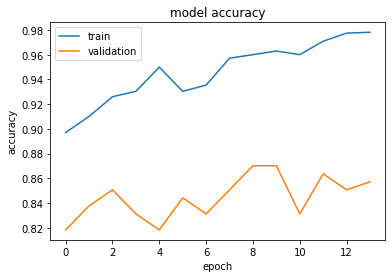

In [20]:
hist = model2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[callback])
plot_hist(hist)

In [21]:
model_eval = model2.evaluate(X_test, y_test, return_dict=True)
model_eval

6/6 [==============================] - 0s 36ms/step - loss: 0.3682 - accuracy: 0.8448


{'loss': 0.36823570728302, 'accuracy': 0.8448275923728943}

In [22]:
preds = model2.predict(X_test)
preds1 = []
for pred in preds:
    if pred > 0.5:
        preds1.append(1)
    else:
        preds1.append(0)

print('**MODEL 2**')
cm1 = confusion_matrix(y_test, preds1)
print(f'Matriu de confusió: \n', cm1)
print('********'*7)
cr1 = classification_report(y_test, preds1)
print('Informe de la classificació: \n', cr1)
print('********'*7)
print('F1 Score: ',f1_score(y_test, preds1))
print('********'*7)
print('Resultats sobre test: ', model_eval)

**MODEL 2**
Matriu de confusió: 
 [[73 19]
 [ 8 74]]
********************************************************
Informe de la classificació: 
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        92
           1       0.80      0.90      0.85        82

    accuracy                           0.84       174
   macro avg       0.85      0.85      0.84       174
weighted avg       0.85      0.84      0.84       174

********************************************************
F1 Score:  0.8457142857142856
********************************************************
Resultats sobre test:  {'loss': 0.36823570728302, 'accuracy': 0.8448275923728943}


## Model 3

In [23]:
model3 = keras.models.clone_model(model2)
model3.set_weights(model2.get_weights())

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [24]:
for layer in model3.layers:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
model3.summary()

Model: "Model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputLayer (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
poolingLayer (GlobalAverageP (None, 1280)              0         
_________________________________________________________________
batchLayer (BatchNormalizati (None, 1280)              5120      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
outputLayer (Dense)          (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 4,011,389
Non-trainable params: 44,583
_____________________________________________

Epoch 1/100
44/44 [==============================] - 21s 267ms/step - loss: 0.0844 - accuracy: 0.9746 - val_loss: 0.3417 - val_accuracy: 0.8442
Epoch 2/100
44/44 [==============================] - 10s 233ms/step - loss: 0.0695 - accuracy: 0.9826 - val_loss: 0.3084 - val_accuracy: 0.8701
Epoch 3/100
44/44 [==============================] - 10s 235ms/step - loss: 0.0756 - accuracy: 0.9811 - val_loss: 0.3669 - val_accuracy: 0.8766
Epoch 4/100
44/44 [==============================] - 10s 237ms/step - loss: 0.0603 - accuracy: 0.9848 - val_loss: 0.3605 - val_accuracy: 0.8571
Epoch 5/100
44/44 [==============================] - 10s 233ms/step - loss: 0.0516 - accuracy: 0.9891 - val_loss: 0.3466 - val_accuracy: 0.8766
Epoch 6/100
44/44 [==============================] - 10s 235ms/step - loss: 0.0516 - accuracy: 0.9884 - val_loss: 0.3411 - val_accuracy: 0.8701
Epoch 7/100
44/44 [==============================] - 10s 234ms/step - loss: 0.0590 - accuracy: 0.9848 - val_loss: 0.3271 - val_accuracy:

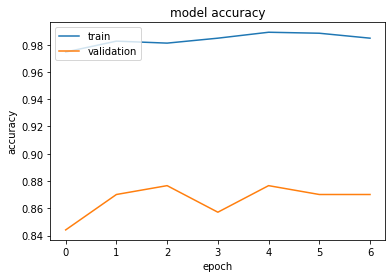

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model3.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
hist = model3.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[callback])
plot_hist(hist)

In [26]:
model_eval = model3.evaluate(X_test, y_test, return_dict=True)
model_eval

6/6 [==============================] - 0s 40ms/step - loss: 0.3135 - accuracy: 0.8793


{'loss': 0.31348639726638794, 'accuracy': 0.8793103694915771}

In [27]:
preds = model3.predict(X_test)
preds1 = []
for pred in preds:
    if pred > 0.5:
        preds1.append(1)
    else:
        preds1.append(0)

print('**MODEL 3**')
cm1 = confusion_matrix(y_test, preds1)
print(f'Matriu de confusió: \n', cm1)
print('********'*7)
cr1 = classification_report(y_test, preds1)
print('Informe de la classificació: \n', cr1)
print('********'*7)
print('F1 Score: ',f1_score(y_test, preds1))
print('********'*7)
print('Resultats sobre test: ', model_eval)

**MODEL 3**
Matriu de confusió: 
 [[79 13]
 [ 8 74]]
********************************************************
Informe de la classificació: 
               precision    recall  f1-score   support

           0       0.91      0.86      0.88        92
           1       0.85      0.90      0.88        82

    accuracy                           0.88       174
   macro avg       0.88      0.88      0.88       174
weighted avg       0.88      0.88      0.88       174

********************************************************
F1 Score:  0.8757396449704142
********************************************************
Resultats sobre test:  {'loss': 0.31348639726638794, 'accuracy': 0.8793103694915771}


## Model 5

In [28]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu',input_shape=(224, 224, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid"),
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0

Epoch 1/50
87/87 [==============================] - 6s 53ms/step - loss: 2.0836 - accuracy: 0.6584 - val_loss: 0.6247 - val_accuracy: 0.6753
Epoch 2/50
87/87 [==============================] - 4s 45ms/step - loss: 0.6383 - accuracy: 0.6323 - val_loss: 0.6314 - val_accuracy: 0.6039
Epoch 3/50
87/87 [==============================] - 4s 45ms/step - loss: 0.5728 - accuracy: 0.7310 - val_loss: 0.6057 - val_accuracy: 0.7143
Epoch 4/50
87/87 [==============================] - 4s 45ms/step - loss: 0.4655 - accuracy: 0.7970 - val_loss: 0.5359 - val_accuracy: 0.7532
Epoch 5/50
87/87 [==============================] - 4s 45ms/step - loss: 0.5181 - accuracy: 0.7556 - val_loss: 0.5472 - val_accuracy: 0.7468
Epoch 6/50
87/87 [==============================] - 4s 48ms/step - loss: 0.4645 - accuracy: 0.7897 - val_loss: 0.4984 - val_accuracy: 0.7597
Epoch 7/50
87/87 [==============================] - 4s 45ms/step - loss: 0.4400 - accuracy: 0.8100 - val_loss: 0.4864 - val_accuracy: 0.7597
Epoch 8/50
87

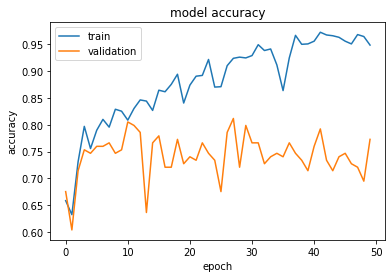

In [29]:
# Compile
# TODO
model.compile(keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenament del model
# TODO
history = model.fit(X_train, y_train,
          validation_data = (X_val, y_val),
          epochs=50,
          batch_size=16,
          verbose = 1,
          callbacks=[callback])
plot_hist(history)

In [30]:
model_eval = model.evaluate(X_test, y_test, return_dict=True)

6/6 [==============================] - 1s 90ms/step - loss: 0.4728 - accuracy: 0.8161


In [31]:
preds = model.predict(X_test)
preds1 = []
for pred in preds:
    if pred > 0.5:
        preds1.append(1)
    else:
        preds1.append(0)

print('**MODEL 5**')
cm1 = confusion_matrix(y_test, preds1)
print(f'Matriu de confusió: \n', cm1)
print('********'*7)
cr1 = classification_report(y_test, preds1)
print('Informe de la classificació: \n', cr1)
print('********'*7)
print('F1 Score: ',f1_score(y_test, preds1))
print('********'*7)
print('Resultats sobre test: ', model_eval)

**MODEL 5**
Matriu de confusió: 
 [[75 17]
 [15 67]]
********************************************************
Informe de la classificació: 
               precision    recall  f1-score   support

           0       0.83      0.82      0.82        92
           1       0.80      0.82      0.81        82

    accuracy                           0.82       174
   macro avg       0.82      0.82      0.82       174
weighted avg       0.82      0.82      0.82       174

********************************************************
F1 Score:  0.8072289156626505
********************************************************
Resultats sobre test:  {'loss': 0.47280147671699524, 'accuracy': 0.8160919547080994}


### Model 4

In [32]:
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(224,224,3)))
model.add(Conv2D(32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

In [33]:
# Compile
# TODO
model.compile(keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenament del model
# TODO
history = model.fit(X_train, y_train,
          validation_data = (X_val, y_val),
          epochs=50,
          batch_size=16,
          verbose = 1,
          callbacks=[callback])

Epoch 1/50
87/87 [==============================] - 3s 31ms/step - loss: 82.8830 - accuracy: 0.5410 - val_loss: 0.7167 - val_accuracy: 0.5390
Epoch 2/50
87/87 [==============================] - 2s 27ms/step - loss: 2.2561 - accuracy: 0.5497 - val_loss: 0.7628 - val_accuracy: 0.5390
Epoch 3/50
87/87 [==============================] - 2s 27ms/step - loss: 0.6731 - accuracy: 0.5591 - val_loss: 0.7727 - val_accuracy: 0.5390
Epoch 4/50
87/87 [==============================] - 2s 27ms/step - loss: 0.7129 - accuracy: 0.5598 - val_loss: 0.9022 - val_accuracy: 0.5325
Epoch 5/50
87/87 [==============================] - 2s 27ms/step - loss: 0.6655 - accuracy: 0.5620 - val_loss: 0.7416 - val_accuracy: 0.5390
Epoch 6/50
87/87 [==============================] - 2s 27ms/step - loss: 0.6632 - accuracy: 0.5627 - val_loss: 0.8472 - val_accuracy: 0.5390


In [34]:
model_eval = model.evaluate(X_test, y_test, return_dict=True)

preds = model.predict(X_test)
preds1 = []
for pred in preds:
    if pred > 0.5:
        preds1.append(1)
    else:
        preds1.append(0)

print('**MODEL 4**')
cm1 = confusion_matrix(y_test, preds1)
print(f'Matriu de confusió: \n', cm1)
print('********'*7)
cr1 = classification_report(y_test, preds1)
print('Informe de la classificació: \n', cr1)
print('********'*7)
print('F1 Score: ',f1_score(y_test, preds1))
print('********'*7)
print('Resultats sobre test: ', model_eval)

6/6 [==============================] - 1s 42ms/step - loss: 0.8524 - accuracy: 0.4598
**MODEL 4**
Matriu de confusió: 
 [[ 0 92]
 [ 2 80]]
********************************************************
Informe de la classificació: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.47      0.98      0.63        82

    accuracy                           0.46       174
   macro avg       0.23      0.49      0.31       174
weighted avg       0.22      0.46      0.30       174

********************************************************
F1 Score:  0.6299212598425197
********************************************************
Resultats sobre test:  {'loss': 0.8523510694503784, 'accuracy': 0.4597701132297516}


In [35]:
best_model = keras.models.clone_model(model3)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [36]:
def get_best_model():
    best_model.set_weights(model2.get_weights()) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    best_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return best_model

In [37]:
df = pd.DataFrame()
df_test_accuracy = pd.DataFrame()

In [38]:
# K-fold Train and test for each split

for fold in os.listdir('../input/glaucoma/archive/practica_DL_UOC_2022/'):
    print ('Processing ', fold, '...')
    X_train, y_train = process_images_folder(f'../input/glaucoma/archive/practica_DL_UOC_2022/{fold}/train')
    X_test, y_test = process_images_folder(f'../input/glaucoma/archive/practica_DL_UOC_2022/{fold}/test')
    X_val, y_val = process_images_folder(f'../input/glaucoma/archive/practica_DL_UOC_2022/{fold}/valid')
    model = get_best_model()
    print('Training model...')
    hist = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[callback], verbose=1)
    model_eval = model.evaluate(X_test, y_test, return_dict=True)
    preds = model.predict(X_test)
    preds_ = []
    for pred in preds:
        if pred > 0.5:
            preds_.append(1)
        else:
            preds_.append(0)
    print(classification_report(y_test, preds_))
    df[fold] = [f1_score(y_test, preds_, average='macro')]
    df_test_accuracy[fold] = model_eval

Processing  Fold7 ...
Training model...
Epoch 1/100
44/44 [==============================] - 22s 267ms/step - loss: 0.1645 - accuracy: 0.9413 - val_loss: 0.1415 - val_accuracy: 0.9481
Epoch 2/100
44/44 [==============================] - 10s 234ms/step - loss: 0.1330 - accuracy: 0.9456 - val_loss: 0.1318 - val_accuracy: 0.9610
Epoch 3/100
44/44 [==============================] - 10s 236ms/step - loss: 0.1202 - accuracy: 0.9529 - val_loss: 0.1043 - val_accuracy: 0.9740
Epoch 4/100
44/44 [==============================] - 10s 233ms/step - loss: 0.1000 - accuracy: 0.9703 - val_loss: 0.1155 - val_accuracy: 0.9740
Epoch 5/100
44/44 [==============================] - 10s 232ms/step - loss: 0.0976 - accuracy: 0.9688 - val_loss: 0.1087 - val_accuracy: 0.9610
Epoch 6/100
44/44 [==============================] - 10s 236ms/step - loss: 0.0818 - accuracy: 0.9768 - val_loss: 0.0983 - val_accuracy: 0.9740
Epoch 7/100
44/44 [==============================] - 10s 234ms/step - loss: 0.0834 - accuracy: 0

In [39]:
df

,Fold7,Fold1,Fold3,Fold5,Fold0,Fold9,Fold8,Fold4,Fold2,Fold6
0,0.976486,0.982744,0.953803,0.907741,0.896333,0.946798,0.947986,0.953723,0.941414,0.959469


In [40]:
df_test_accuracy

,Fold7,Fold1,Fold3,Fold5,Fold0,Fold9,Fold8,Fold4,Fold2,Fold6
loss,loss,loss,loss,loss,loss,loss,loss,loss,loss,loss
accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy
